In [28]:
#imports
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [10]:
start = '2013-01-01'
end = '2023-01-01'

ticker = 'AAPL'

data = yf.download(ticker, start, end)


[*********************100%%**********************]  1 of 1 completed


In [11]:
data.reset_index(inplace=True)
data.dropna(inplace=True)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.779285,19.821428,19.343929,19.608213,16.769093,560518000
1,2013-01-03,19.567142,19.631071,19.321428,19.360714,16.557434,352965200
2,2013-01-04,19.177500,19.236786,18.779642,18.821428,16.096228,594333600
3,2013-01-07,18.642857,18.903570,18.400000,18.710714,16.001543,484156400
4,2013-01-08,18.900356,18.996071,18.616072,18.761070,16.044609,458707200
...,...,...,...,...,...,...,...
2513,2022-12-23,130.919998,132.419998,129.639999,131.860001,131.127060,63814900
2514,2022-12-27,131.380005,131.410004,128.720001,130.029999,129.307236,69007800
2515,2022-12-28,129.669998,131.029999,125.870003,126.040001,125.339417,85438400
2516,2022-12-29,127.989998,130.479996,127.730003,129.610001,128.889557,75703700


### Preprosessing

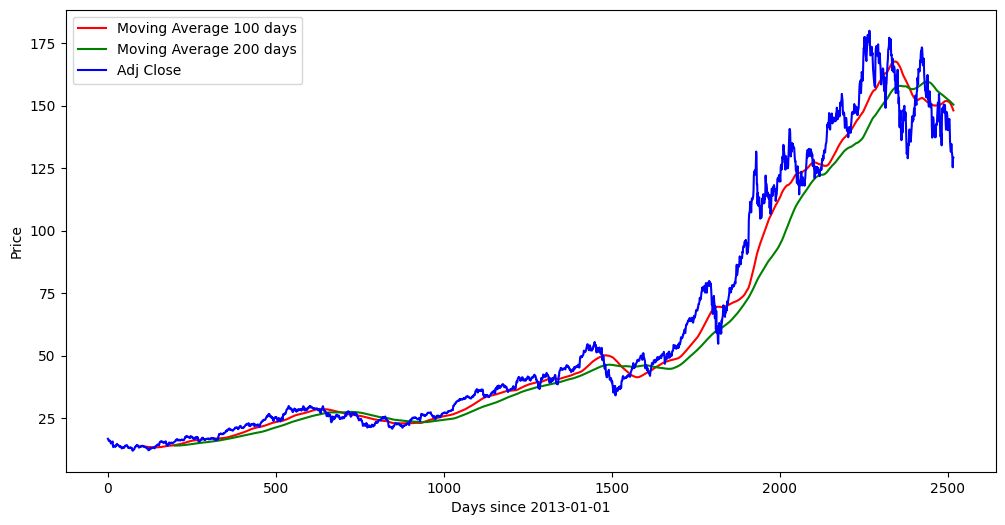

In [14]:

# moving averages and plotting
ma_100 = data['Adj Close'].rolling(100).mean()
ma_200 = data['Adj Close'].rolling(200).mean()
plt.figure(figsize=(12,6))
plt.plot(ma_100, 'r', label='Moving Average 100 days')
plt.plot(ma_200, 'g', label='Moving Average 200 days')
plt.plot(data['Adj Close'], 'b', label='Adj Close')
plt.legend(loc='upper left')
plt.xlabel('Days since 2013-01-01')
plt.ylabel('Price')
plt.show()

In [19]:
#train test split
train = data['Adj Close'][0:int(0.8*(len(data)))]
test = data['Adj Close'][int(0.8*(len(data))):len(data)]

print(train.shape[0])
print(test.shape[0])

2014
504


In [27]:
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train.values.reshape(-1,1))

In [29]:
#Splitting array, using previous 100 days to predict next day

x = []
y = []

for i in range(100, train_scaled.shape[0]):
    x.append(train_scaled[i-100:i])
    y.append(train_scaled[i, 0])
    
x, y = np.array(x), np.array(y)


In [30]:
#model creation

model = Sequential()

model.add(LSTM(units = 50, activation='relu', return_sequences=True, input_shape=(x.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [32]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [33]:
model.fit(x, y, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
60/60 [==============================] - 13s 165ms/step - loss: 0.0199
Epoch 2/50
60/60 [==============================] - 10s 160ms/step - loss: 0.0044
Epoch 3/50
60/60 [==============================] - 10s 163ms/step - loss: 0.0031
Epoch 4/50
60/60 [==============================] - 10s 163ms/step - loss: 0.0047
Epoch 5/50
60/60 [==============================] - 10s 164ms/step - loss: 0.0030
Epoch 6/50
60/60 [==============================] - 10s 169ms/step - loss: 0.0030
Epoch 7/50
60/60 [==============================] - 10s 163ms/step - loss: 0.0031
Epoch 8/50
60/60 [==============================] - 10s 163ms/step - loss: 0.0036
Epoch 9/50
60/60 [==============================] - 10s 163ms/step - loss: 0.0032
Epoch 10/50
60/60 [==============================] - 10s 162ms/step - loss: 0.0027
Epoch 11/50
60/60 [==============================] - 10s 162ms/step - loss: 0.0020
Epoch 12/50
60/60 [==============================] - 10s 164ms/step - loss: 0.0026
Epoch 13/50
6

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [37]:
#testing model
past_100_days = train.tail(100)
data_test = pd.concat((past_100_days, test), ignore_index=True)

data_test_scaled = scaler.fit_transform(data_test.values.reshape(-1,1))

In [40]:
x = []
y = []

for i in range(100, data_test_scaled.shape[0]):
    x.append(data_test_scaled[i-100:i])
    y.append(data_test_scaled[i, 0])
    
x, y = np.array(x), np.array(y)

In [42]:
y_predict = model.predict(x)

16/16 [==============================] - 1s 40ms/step


In [43]:
scale = 1/scaler.scale_
y_predict = y_predict*scale
y = y*scale

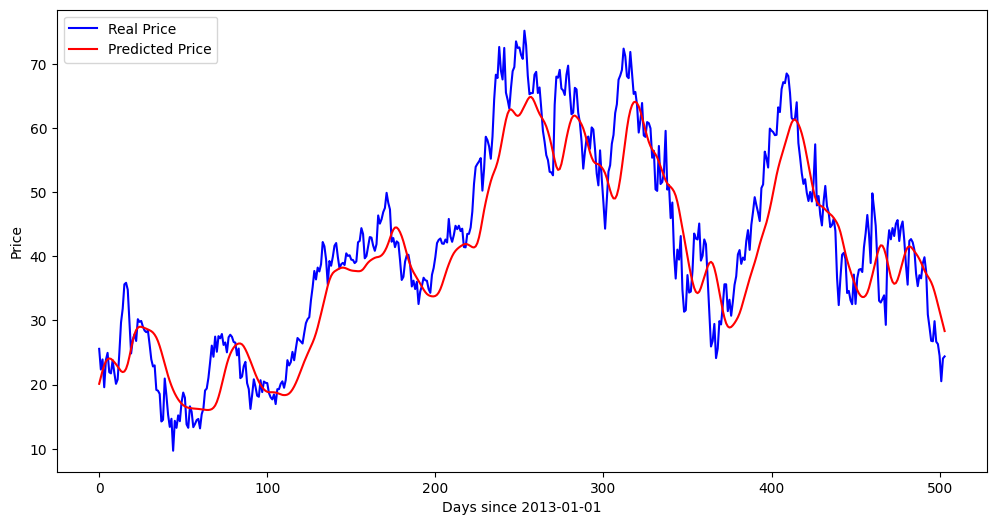

In [44]:
#plotting results

plt.figure(figsize=(12,6))
plt.plot(y, 'b', label='Real Price')
plt.plot(y_predict, 'r', label='Predicted Price')
plt.xlabel('Days since 2013-01-01')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

In [45]:
model.save('stock_predictor.keras')